# Нейрон с различными функциями активации

В этом задании нужно будет:
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке).

In [ ]:
def Loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

## Нейрон с ReLU (Recitified Linear Unit)

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [ ]:
def relu(x):
    """ReLU-функция"""
    return np.where(x <= 0, 0, x)

In [ ]:
def relu_derivative(x):
    """Производная ReLU"""
    return np.where(x <= 0, 0, 1)

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b


    def activate(self, x):
        return relu(x)


    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)

    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)

        grad_w = np.zeros((X.shape[1], 1))
        grad_b = 0

        for i in range(len(X)):
          if y_pred[i] > 0:
            grad_w += X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            grad_b += y_pred[i] - y[i]

        self.w = self.w - learning_rate * grad_w / n
        self.b = self.b - learning_rate * grad_b / n

    def fit(self, X, y, num_epochs):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """

        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
            # self.b = 0  # смещение (число)

        Loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(np.array(X))
            # считаем функцию потерь с текущими весами
            Loss_values.append(Loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self.backward_pass(X, y, y_pred)

        return Loss_values

    def predict(self, X, threshold):
        return np.array(self.forward_pass(X) > threshold).ravel()

<h3 style="text-align: center;"><b>Тестирование нейрона с ReLU</b></h3>  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести:
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

In [ ]:
!gdown 1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1
fruits_data = pd.read_csv(filepath_or_buffer = "apples_pears.csv")

Downloading...
From: https://drive.google.com/uc?id=1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1
To: /content/apples_pears.csv
100% 43.6k/43.6k [00:00<00:00, 91.0MB/s]


In [ ]:
fruits_data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


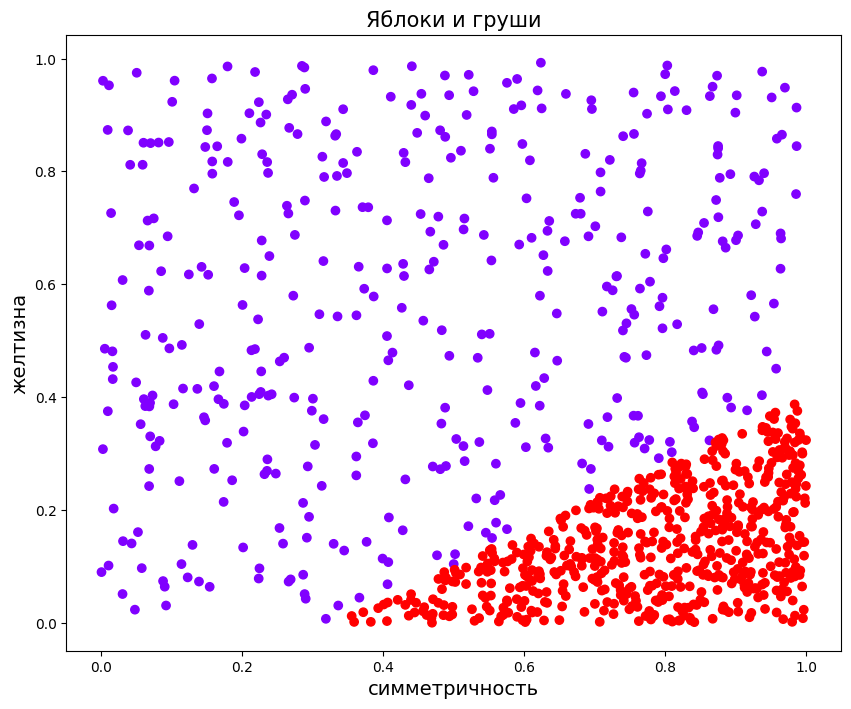

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(fruits_data.iloc[:, 0], fruits_data.iloc[:, 1], c=fruits_data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X = fruits_data.iloc[:,:2].values  # матрица объекты-признаки
y = fruits_data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

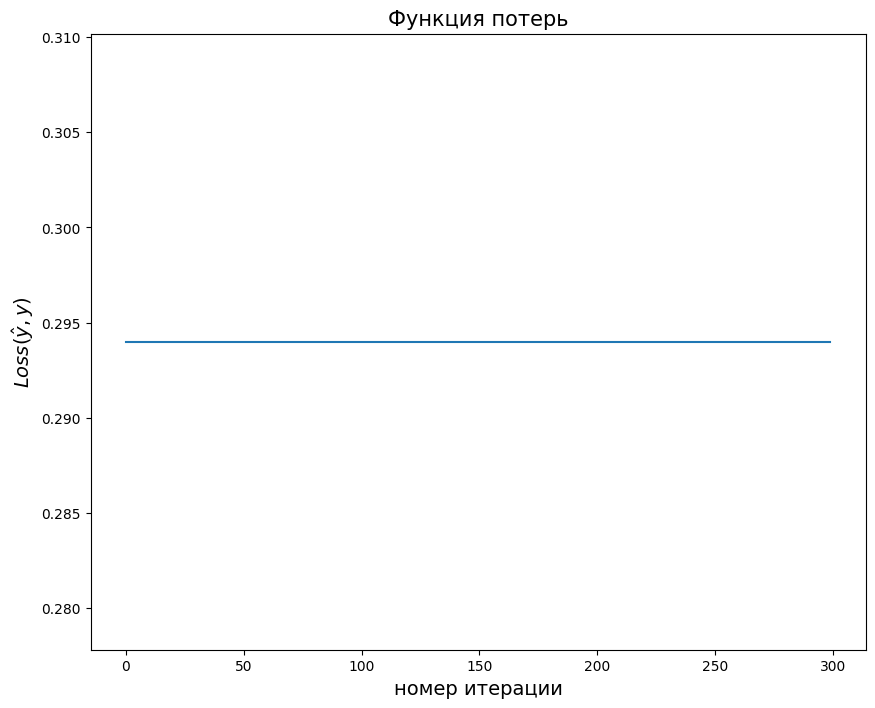

CPU times: user 1.42 s, sys: 53.2 ms, total: 1.47 s
Wall time: 1.81 s


In [ ]:
%%time

neuron = NeuronReLU()
Loss_values = neuron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями.

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций).

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU`

### Тестирование нейрона с ReLU на фруктах

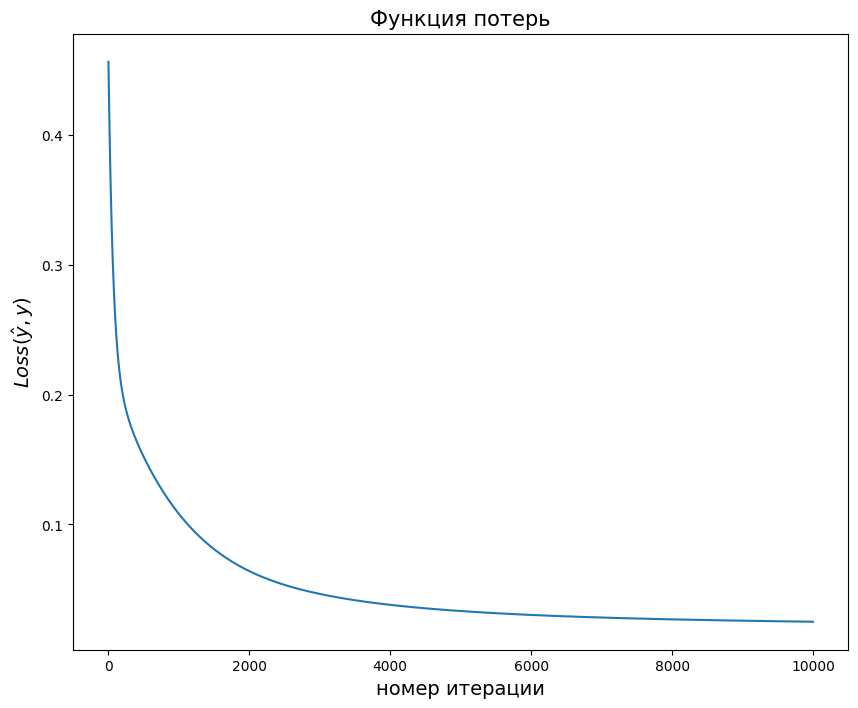

CPU times: user 1min 40s, sys: 205 ms, total: 1min 40s
Wall time: 1min 53s


In [ ]:
%%time

neuron = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как предсказывает этот нейрон:

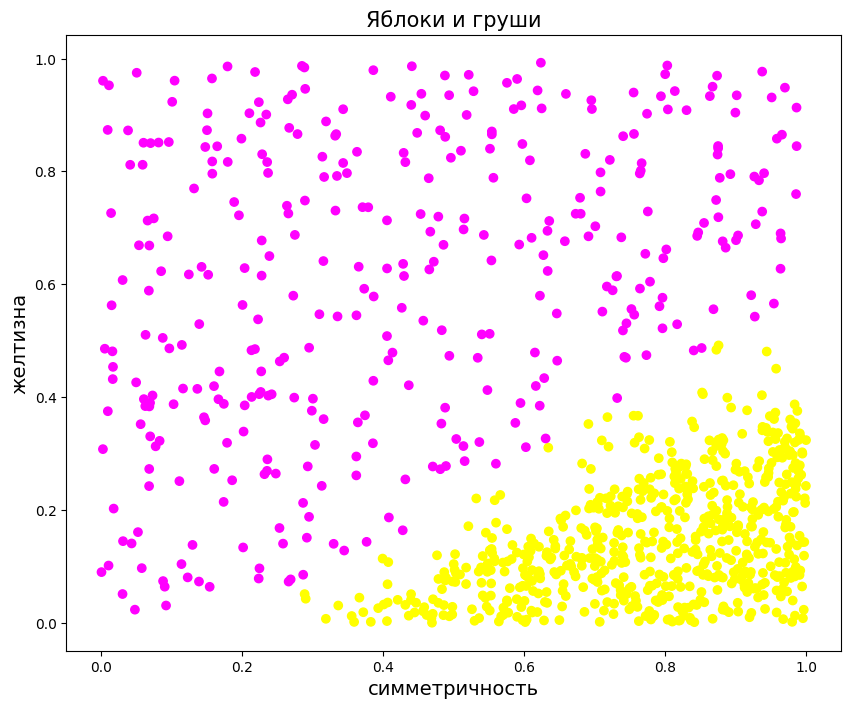

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(fruits_data.iloc[:, 0], fruits_data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X_train = fruits_data.iloc[:int(len(fruits_data)*0.7), :-1]
y_train = fruits_data.iloc[:int(len(fruits_data)*0.7), -1]

X_test = fruits_data.iloc[int(len(fruits_data)*0.7):, :-1]
y_test = fruits_data.iloc[int(len(fruits_data)*0.7):, -1]

In [ ]:
neuron = NeuronReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
neuron.fit(X_train.values, y_train.values, 10000)
thresholds = np.arange(0.001, 1, 0.001)
accuracy = []

for t in thresholds:
  accuracy.append(accuracy_score(y_test.values, neuron.predict(X_test.values, t)))

print("Best threshold: ", round(thresholds[np.argmax(accuracy)], 3))
print("Best accuracy: ", max(accuracy))

Best threshold:  0.613
Best accuracy:  0.99


### Тестирование нейрона с ReLU на голосах

In [ ]:
!gdown 1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR
voice_data = pd.read_csv(filepath_or_buffer = "voice.csv")

Downloading...
From: https://drive.google.com/uc?id=1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR
To: /content/voice.csv
100% 1.07M/1.07M [00:00<00:00, 143MB/s]


In [ ]:
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Перед началом работы надо:
1.   Преобразовать столбец label
2.   Нормализовать данные



In [ ]:
from sklearn import preprocessing

voice_data['label'] = voice_data['label'].map({'male': 0, 'female': 1})
scaler = preprocessing.MinMaxScaler()

names = voice_data.columns
d = scaler.fit_transform(voice_data)

voice_scaled_data = pd.DataFrame(d, columns=names)
voice_scaled_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.096419,0.473409,0.084125,0.060063,0.204956,0.254828,0.367853,0.208279,0.635798,0.564526,...,0.096419,0.157706,0.030501,0.981526,0.000000,0.006452,0.000000,0.000000,0.000000,0.0
1,0.125828,0.505075,0.116900,0.077635,0.215683,0.246961,0.644279,0.483766,0.630964,0.591578,...,0.125828,0.287642,0.031140,0.834600,0.000407,0.006452,0.002144,0.002146,0.056449,0.0
2,0.179222,0.675536,0.102873,0.034284,0.385912,0.457148,0.885255,0.782275,0.442738,0.548382,...,0.179222,0.236945,0.030264,0.954963,0.000060,0.006452,0.000357,0.000358,0.049885,0.0
3,0.528261,0.554611,0.587559,0.389906,0.715802,0.407358,0.031549,0.001613,0.923261,0.856457,...,0.528261,0.183442,0.041287,0.834600,0.065659,0.006452,0.025375,0.025393,0.265043,0.0
4,0.452195,0.627209,0.454272,0.317627,0.707515,0.474474,0.027742,0.001732,0.958736,0.926348,...,0.452195,0.279190,0.036829,0.929285,0.238994,0.006452,0.250536,0.250715,0.223380,0.0


In [ ]:
X = voice_scaled_data.iloc[:,:-1].values  # матрица объекты-признаки
y = voice_scaled_data['label'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

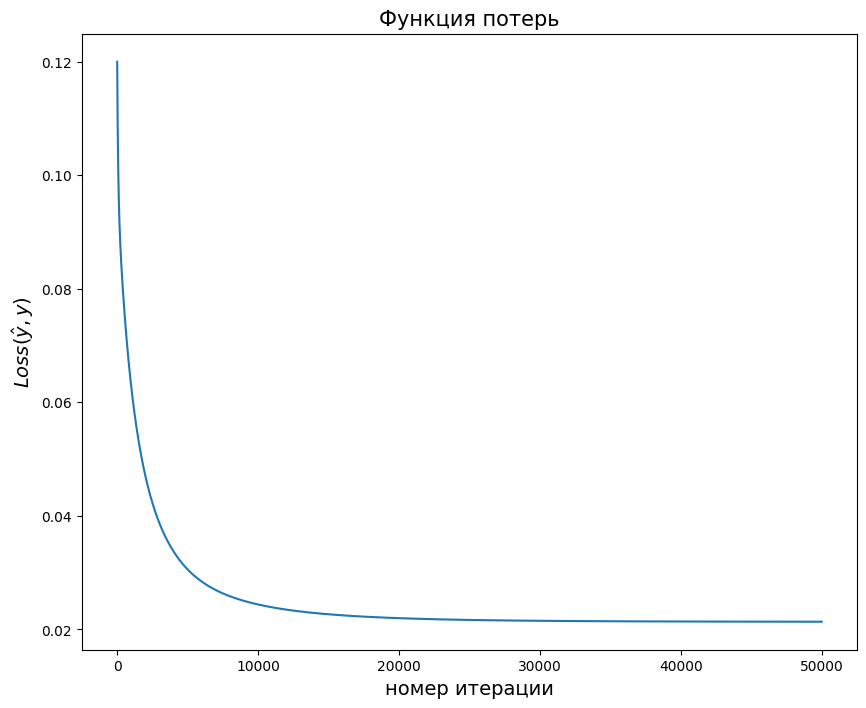

CPU times: user 7min 4s, sys: 862 ms, total: 7min 5s
Wall time: 7min 32s


In [ ]:
%%time

neuron = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=50000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
import numpy as np

# Создаем индексы для перемешивания данных
indices = np.arange(voice_scaled_data.shape[0])
np.random.shuffle(indices)

# Используем перемешанные индексы для получения перемешанных данных
X_train = voice_scaled_data.iloc[indices[:int(len(voice_scaled_data)*0.7)], :-1]
y_train = voice_scaled_data.iloc[indices[:int(len(voice_scaled_data)*0.7)], -1]

X_test = voice_scaled_data.iloc[indices[int(len(voice_scaled_data)*0.7):], :-1]
y_test = voice_scaled_data.iloc[indices[int(len(voice_scaled_data)*0.7):], -1]

In [ ]:
neuron = NeuronReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
neuron.fit(X_train.values, y_train.values, 10000)
thresholds = np.arange(0.001, 1, 0.001)
accuracy = []

for t in thresholds:
  accuracy.append(accuracy_score(y_test.values, neuron.predict(X_test.values, t)))

print("Best threshold: ", round(thresholds[np.argmax(accuracy)], 3))
print("Best accuracy: ", max(accuracy))

Best threshold:  0.389
Best accuracy:  0.9589905362776026


Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

## Нейрон с LeakyReLU (Leaky Recitified Linear Unit)

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) =
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [ ]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x <= 0, alpha * x, x)

In [ ]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x <= 0, alpha, x)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0, alpha=0.01):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        self.alpha = alpha



    def activate(self, x):
        return relu(x)


    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)

    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)

        grad_w = np.zeros((X.shape[1], 1))
        grad_b = 0

        for i in range(len(X)):
          if y_pred[i] > 0:
            grad_w += X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            grad_b += y_pred[i] - y[i]
          else:
            grad_w += self.alpha * (X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1)))
            grad_b += self.alpha * (y_pred[i] - y[i])

        self.w = self.w - learning_rate * grad_w / n
        self.b = self.b - learning_rate * grad_b / n

    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
#         self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
#         self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            Loss_values.append(Loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self.backward_pass(X, y, y_pred)

        return Loss_values

    def predict(self, X, threshold):
        return np.array(self.forward_pass(X) > threshold).ravel()

### Тестирование нейрона с LeakyReLU на фруктах

In [ ]:
X = fruits_data.iloc[:,:2].values  # матрица объекты-признаки
y = fruits_data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

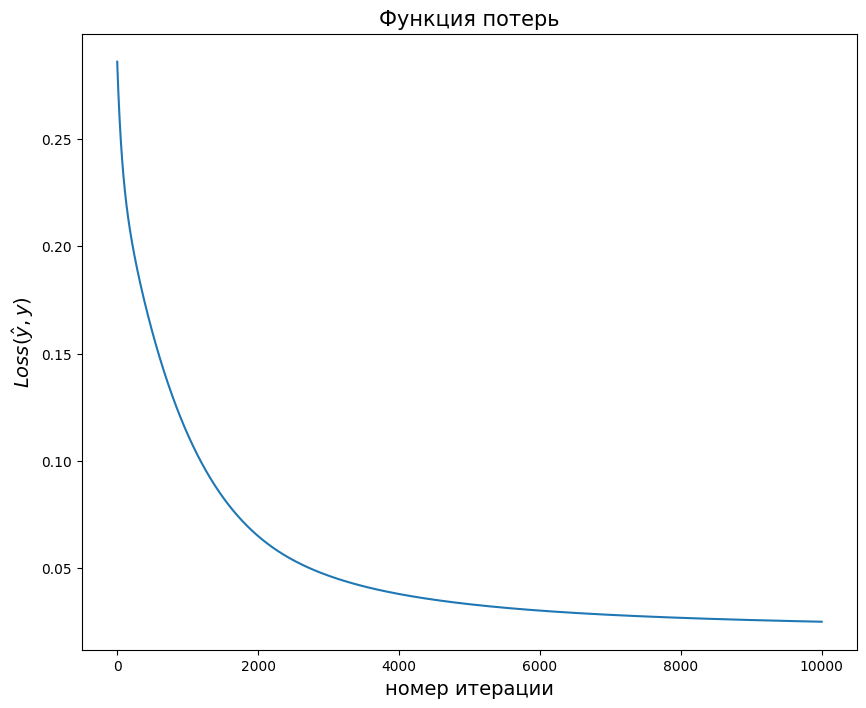

CPU times: user 1min 48s, sys: 290 ms, total: 1min 48s
Wall time: 1min 58s


In [ ]:
%%time

neuron = NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10_000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

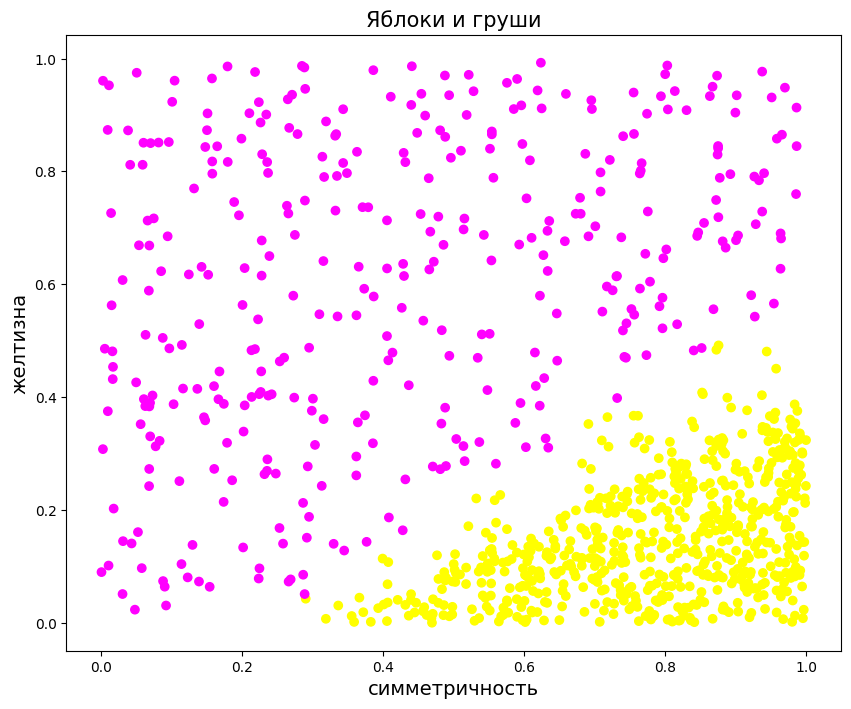

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(fruits_data.iloc[:, 0], fruits_data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X_train = fruits_data.iloc[:int(len(fruits_data)*0.7), :-1]
y_train = fruits_data.iloc[:int(len(fruits_data)*0.7), -1]

X_test = fruits_data.iloc[int(len(fruits_data)*0.7):, :-1]
y_test = fruits_data.iloc[int(len(fruits_data)*0.7):, -1]

In [ ]:
neuron = NeuronLeakyReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
neuron.fit(X_train.values, y_train.values, 10000)
thresholds = np.arange(0.001, 1, 0.001)
accuracy = []

for t in thresholds:
  accuracy.append(accuracy_score(y_test.values, neuron.predict(X_test.values, t)))

print("Best threshold: ", round(thresholds[np.argmax(accuracy)], 3))
print("Best accuracy: ", max(accuracy))

Best threshold:  0.633
Best accuracy:  0.9933333333333333


### Тестирование нейрона с LeakyReLU на голосах

In [ ]:
X = voice_scaled_data.iloc[:,:-1].values  # матрица объекты-признаки
y = voice_scaled_data['label'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

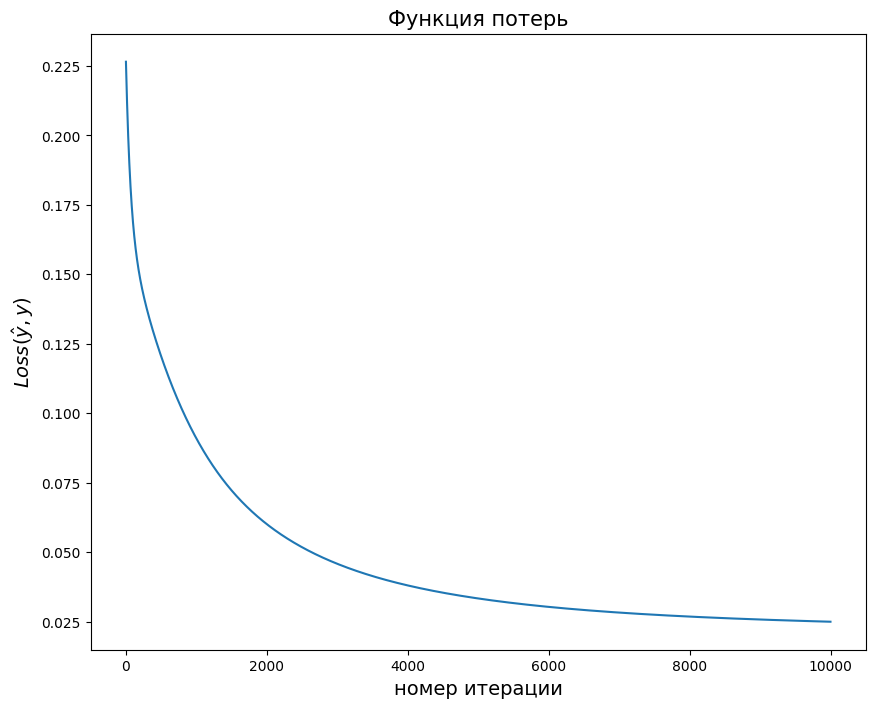

CPU times: user 1min 46s, sys: 269 ms, total: 1min 46s
Wall time: 1min 47s


In [ ]:
%%time

neuron = NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10_000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
import numpy as np

# Создаем индексы для перемешивания данных
indices = np.arange(voice_scaled_data.shape[0])
np.random.shuffle(indices)

# Используем перемешанные индексы для получения перемешанных данных
X_train = voice_scaled_data.iloc[indices[:int(len(voice_scaled_data)*0.7)], :-1]
y_train = voice_scaled_data.iloc[indices[:int(len(voice_scaled_data)*0.7)], -1]

X_test = voice_scaled_data.iloc[indices[int(len(voice_scaled_data)*0.7):], :-1]
y_test = voice_scaled_data.iloc[indices[int(len(voice_scaled_data)*0.7):], -1]

In [ ]:
neuron = NeuronLeakyReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
neuron.fit(X_train.values, y_train.values, 10000)
thresholds = np.arange(0.1, 1, 0.01)
accuracy = []

for t in thresholds:
  accuracy.append(accuracy_score(y_test.values, neuron.predict(X_test.values, t)))

print("Best threshold: ", round(thresholds[np.argmax(accuracy)], 3))
print("Best accuracy: ", max(accuracy))

Best threshold:  0.46
Best accuracy:  0.9631966351209253


**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

## Нейрон с ELU (Exponential Linear Unit)

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) =
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [ ]:
def eelu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x <= 0, alpha * (np.exp(x) - 1), x)

In [ ]:
def elu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x <= 0, eelu(x, alpha) + alpha, x)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronELU:
    def __init__(self, w=None, b=0, alpha=0.01):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        self.alpha = alpha


    def activate(self, x):
        return eelu(x, self.alpha)


    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)


    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)

        grad_w = np.zeros((X.shape[1], 1))
        grad_b = 0

        for i in range(len(X)):
          if y_pred[i] > 0:
            grad_w += X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            grad_b += y_pred[i] - y[i]
          else:
            grad_w += self.alpha * (X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1)))
            grad_b += self.alpha * (y_pred[i] - y[i])

        self.w = self.w - learning_rate * grad_w / n
        self.b = self.b - learning_rate * grad_b / n

    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
#         self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
#         self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            Loss_values.append(Loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self.backward_pass(X, y, y_pred)
        return Loss_values

    def predict(self, X, threshold):
        return np.array(self.forward_pass(X) > threshold).ravel()

### Тестирование нейрона с ELU на фруктах

In [ ]:
X = fruits_data.iloc[:,:2].values  # матрица объекты-признаки
y = fruits_data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

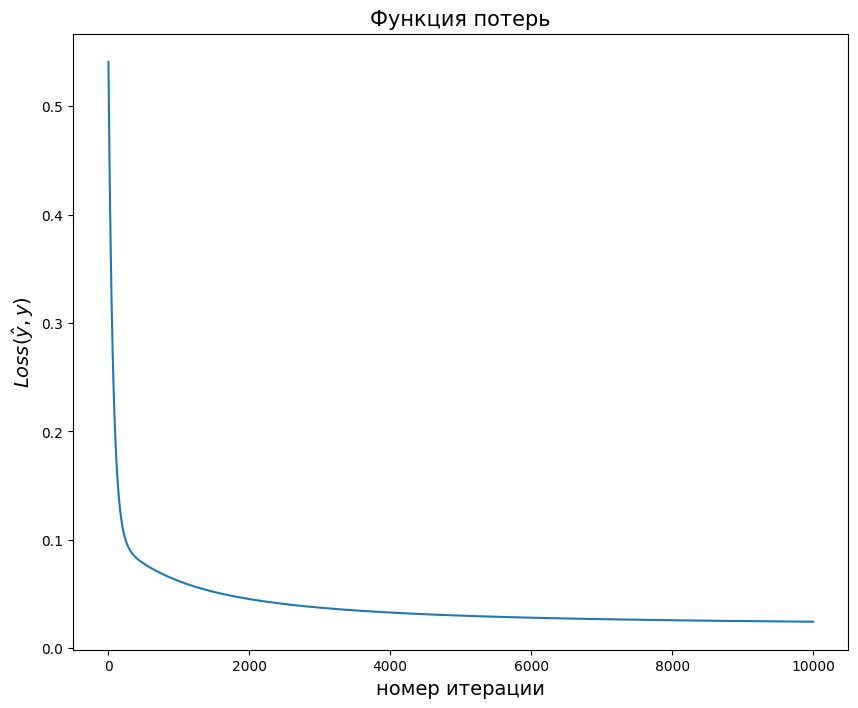

CPU times: user 1min 49s, sys: 236 ms, total: 1min 49s
Wall time: 1min 50s


In [ ]:
%%time

neuron = NeuronELU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10_000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
X_train = fruits_data.iloc[:int(len(fruits_data)*0.7), :-1]
y_train = fruits_data.iloc[:int(len(fruits_data)*0.7), -1]

X_test = fruits_data.iloc[int(len(fruits_data)*0.7):, :-1]
y_test = fruits_data.iloc[int(len(fruits_data)*0.7):, -1]

In [ ]:
neuron = NeuronELU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
neuron.fit(X_train.values, y_train.values, 10000)
thresholds = np.arange(0.001, 1, 0.001)
accuracy = []

for t in thresholds:
  accuracy.append(accuracy_score(y_test.values, neuron.predict(X_test.values, t)))

print("Best threshold: ", round(thresholds[np.argmax(accuracy)], 3))
print("Best accuracy: ", max(accuracy))

Best threshold:  0.64
Best accuracy:  0.9933333333333333


### Тестирование нейрона с ELU на голосах

In [ ]:
X = voice_scaled_data.iloc[:,:-1].values  # матрица объекты-признаки
y = voice_scaled_data['label'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

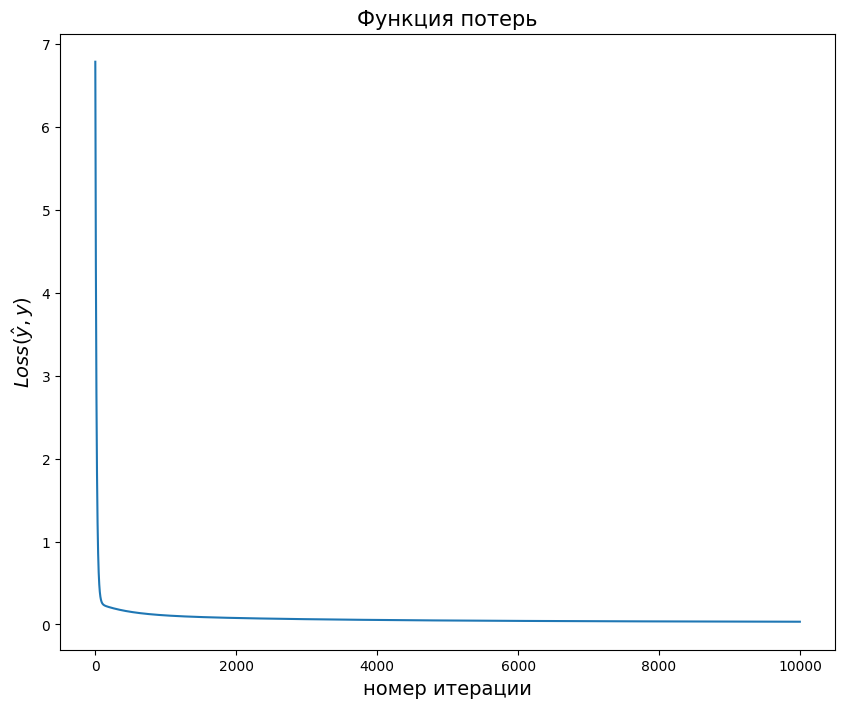

CPU times: user 10min 47s, sys: 8min 6s, total: 18min 53s
Wall time: 11min 14s


In [ ]:
%%time

neuron = NeuronELU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10_000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
import numpy as np

# Создаем индексы для перемешивания данных
indices = np.arange(voice_scaled_data.shape[0])
np.random.shuffle(indices)

# Используем перемешанные индексы для получения перемешанных данных
X_train = voice_scaled_data.iloc[indices[:int(len(voice_scaled_data)*0.7)], :-1]
y_train = voice_scaled_data.iloc[indices[:int(len(voice_scaled_data)*0.7)], -1]

X_test = voice_scaled_data.iloc[indices[int(len(voice_scaled_data)*0.7):], :-1]
y_test = voice_scaled_data.iloc[indices[int(len(voice_scaled_data)*0.7):], -1]

In [ ]:
neuron = NeuronELU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
neuron.fit(X_train.values, y_train.values, 10000)
thresholds = np.arange(0.001, 1, 0.001)
accuracy = []

for t in thresholds:
  accuracy.append(accuracy_score(y_test.values, neuron.predict(X_test.values, t)))

print("Best threshold: ", round(thresholds[np.argmax(accuracy)], 3))
print("Best accuracy: ", max(accuracy))

Best threshold:  0.385
Best accuracy:  0.9516298633017876


**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU